In [ ]:
"""
1. CODE USAGE: python cnn_code.py
2. The code assumes the image size to be 64X64. Please ensure the same!
3. The code saves an excel "output.xlsx" with two columns, GT and Pred.
4. GT is the encoded version of the ground truth and the Pred is the encoded version of prediction
NOTE: Create the dataset as explained in the mail and change the "path_to_dataset" variable accordingly.

"""



############ Give the path of the "datasets" folder here! ###############
path_to_dataset = "/content/drive/MyDrive/datasets"
#########################################################################

########### Reduce this to get better speed. It may also mean lower accuracy. #######
num_epochs = 20
################################################################################################

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd
from time import time

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.conv2 = nn.Conv2d(10, 16, 3)
        self.fc1 = nn.Linear(16 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        #print(size)
        num_features = 1
        for s in size:
            num_features = num_features*s
        return num_features

In [ ]:
time_start = time()
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

data_f1 = datasets.ImageFolder(root = path_to_dataset+'/train',transform = transform)
folderL = DataLoader(data_f1,batch_size = 20,shuffle = True)
dataiter = iter(folderL)
images,labels= next(dataiter)

print(labels)

torch.manual_seed(0)
mini_batch = 20
loss_values = []
for epoch in range(num_epochs):
    for i, data in enumerate(folderL, 0):

        inputs, labels = data


        optimizer.zero_grad()


        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, loss.item()))
        loss_values.append(loss.item())


tensor([0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 2, 2])
[1,     1] loss: 1.093
[1,     2] loss: 1.100
[1,     3] loss: 1.108
[1,     4] loss: 1.122
[1,     5] loss: 1.120
[1,     6] loss: 1.085
[1,     7] loss: 1.100
[1,     8] loss: 1.121
[1,     9] loss: 1.122
[1,    10] loss: 1.098
[1,    11] loss: 1.122
[1,    12] loss: 1.080
[1,    13] loss: 1.096
[1,    14] loss: 1.127
[1,    15] loss: 1.077
[1,    16] loss: 1.106
[1,    17] loss: 1.095
[1,    18] loss: 1.130
[1,    19] loss: 1.114
[1,    20] loss: 1.102
[1,    21] loss: 1.108
[1,    22] loss: 1.104
[1,    23] loss: 1.118
[1,    24] loss: 1.112
[1,    25] loss: 1.103
[1,    26] loss: 1.102
[1,    27] loss: 1.108
[1,    28] loss: 1.112
[1,    29] loss: 1.096
[1,    30] loss: 1.079
[1,    31] loss: 1.104
[1,    32] loss: 1.098
[1,    33] loss: 1.105
[1,    34] loss: 1.115
[1,    35] loss: 1.120
[1,    36] loss: 1.094
[1,    37] loss: 1.070
[1,    38] loss: 1.127
[1,    39] loss: 1.098
[1,    40] loss: 1.121
[1,    41] 

Finished Training
Accuracy of the network on the train images: 100 %
Saved the predictions in the Excel. Use it to calculate the accuracy and F1 score!
Total time taken =  572.543069601059  sec


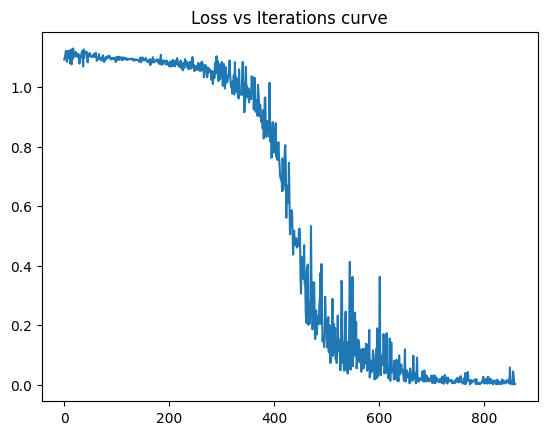

In [ ]:
plt.plot(loss_values)
plt.title("Loss vs Iterations curve")

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in folderL:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))


data_f2 = datasets.ImageFolder(root = path_to_dataset+'/test/',transform = transform)
folderTest = DataLoader(data_f2,batch_size = 1,shuffle = False)

correct = 0
total = 0
gt_arr = []
pred_arr = []
with torch.no_grad():
    for data in folderTest:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        gt_arr.append(labels.numpy()[0])
        pred_arr.append(predicted.numpy()[0])


df = pd.DataFrame({
    'GT': gt_arr,
    'Pred': pred_arr
})

excel_filename = 'output.xlsx'
df.to_excel(excel_filename, index=False)
print("Saved the predictions in the Excel. Use it to calculate the accuracy and F1 score!")



print("Total time taken = ",time()-time_start," sec")

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Load the results from the Excel file
excel_filename = 'output.xlsx'
df = pd.read_excel(excel_filename)

# Extract ground truth and predictions
gt_arr = df['GT'].to_numpy()
pred_arr = df['Pred'].to_numpy()

# Calculate accuracy and F1 score
accuracy = accuracy_score(gt_arr, pred_arr)
f1 = f1_score(gt_arr, pred_arr, average='weighted')

# Print the results
print('Accuracy: %.2f %%' % (100 * accuracy))
print('F1 score: %.2f' % f1)


Accuracy: 97.01 %
F1 score: 0.97
